### Mount google drive and go to directory

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/dip_fp/Term_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/dip_fp/Term_project


### Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import scipy as sp
import glob
import os
from PIL import Image

### Get style image and source image

source_img shape: 643 * 1069
style_img shape: 643 * 1069


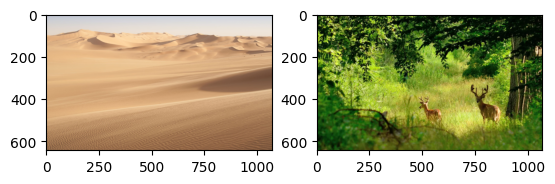

In [6]:
# set image pair number
img_pair_num = 3
source_img_path = "./images/source/img" + str(img_pair_num) + ".png"
style_img_path = "./images/style/img" + str(img_pair_num) + ".png"
_source_img = plt.imread(source_img_path)
_style_img = plt.imread(style_img_path)
height = int(min(_source_img.shape[0], _style_img.shape[0]))
width = int(min(_source_img.shape[1], _style_img.shape[1]))
source_y_start = int(np.floor((_source_img.shape[0]-height)/2))
source_x_start = int(np.floor((_source_img.shape[1]-width)/2))
style_y_start = int(np.floor((_style_img.shape[0]-height)/2))
style_x_start = int(np.floor((_style_img.shape[1]-width)/2))
source_img = _source_img[source_y_start:source_y_start+height, source_x_start:source_x_start+width]
style_img = _style_img[style_y_start:style_y_start+height, style_x_start:style_x_start+width]
print(f'source_img shape: {source_img.shape[0]} * {source_img.shape[1]}')
print(f'style_img shape: {style_img.shape[0]} * {style_img.shape[1]}')

fig, ax = plt.subplots(1,2)
ax[0].imshow(source_img)
ax[1].imshow(style_img)

### Remove image opacity

In [7]:
def remove_opacity(img):
    if img.shape[2] == 3:
        print("the image belongs to rgb")
        return img
    ret_img = np.zeros((height, width, 3), dtype='float32')
    ret_img[:,:,:3] = img[:,:,:3]
    return ret_img

source_img = remove_opacity(source_img)
style_img = remove_opacity(style_img)

### Color transfer basic

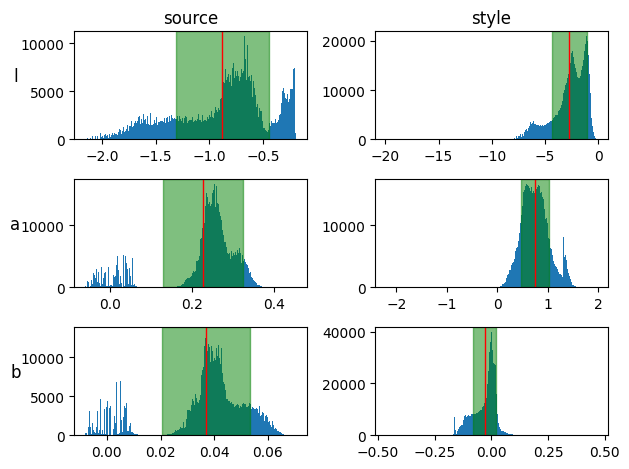

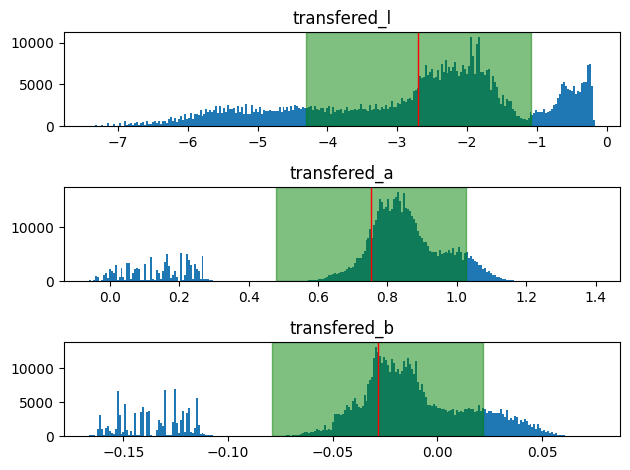

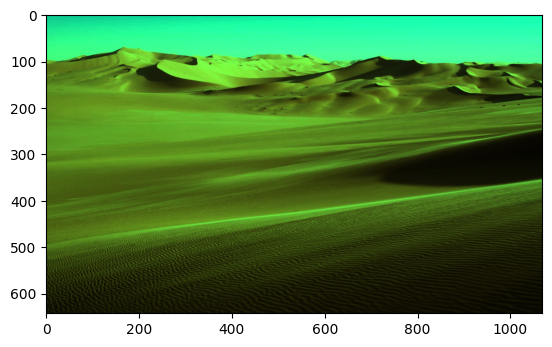

In [8]:
def rgb2lab(img):
    """
    Converting RGB to a decorrelated color space lab
    """
    img = img.astype(np.float32)
    rgb2LMS_matrix = np.array([[0.3811, 0.5783, 0.0402],
                   [0.1967, 0.7244, 0.0782],
                   [0.0241, 0.1288, 0.8444]])
    img = img.reshape((height*width, 3))
    img = np.maximum(img, 1e-5)  # prevent existence of -inf
    LMS_img = img @ rgb2LMS_matrix.T
    LMS_img = np.log(LMS_img)
    LMS2lab_matrix_lhs = np.array([[1/np.sqrt(3),0,0],
                     [0,1/np.sqrt(6),0],
                     [0,0,1/np.sqrt(2)]])
    LMS2lab_matrix_rhs = np.array([[1, 1, 1],
                     [1, 1, -2],
                     [1, -1, 0]])
    LMS2lab_matrix = LMS2lab_matrix_lhs @ LMS2lab_matrix_rhs
    lab_img = LMS_img @ LMS2lab_matrix.T
    lab_img = lab_img.reshape((height, width, 3))
    lab_img = lab_img.astype(np.float32)
    return lab_img

def lab2rgb(img):
    img = img.astype(np.float32)
    lab2LMS_matrix_lhs = np.array([[1, 1, 1],
                     [1, 1, -1],
                     [1, -2, 0]])
    lab2LMS_matrix_rhs = np.array([[1/np.sqrt(3),0,0],
                     [0,1/np.sqrt(6),0],
                     [0,0,1/np.sqrt(2)]])
    lab2LMS_matrix = lab2LMS_matrix_lhs @ lab2LMS_matrix_rhs
    img = img.reshape((height*width, 3))
    LMS_img = img @ lab2LMS_matrix.T
    LMS_img = np.exp(LMS_img)
    LMS2rgb_matrix = np.array([[4.4679, -3.5873, 0.1193],
                   [-1.2186, 2.3809, -0.1624],
                   [0.0497, -0.2439, 1.2045]])
    rgb_img = LMS_img @ LMS2rgb_matrix.T
    rgb_img = rgb_img.reshape((height, width, 3))
    rgb_img = rgb_img.astype(np.float32)
    return rgb_img

def adjust_mean_std(source_img, style_img):
    """
    Adjusting the means and standard deviations of the synthetic image
    """
    source_img, style_img = source_img.astype(np.float32), style_img.astype(np.float32)
    # plot the histograms of 3 channels of source_img and style_img
    source_img_uint8, style_img_uint8 = (source_img*255).astype(np.uint8), (style_img*255).astype(np.uint8)
    source_ls, source_as, source_bs = source_img[:,:,0].flatten(), source_img[:,:,1].flatten(), source_img[:,:,2].flatten()
    style_ls, style_as, style_bs = style_img[:,:,0].flatten(), style_img[:,:,1].flatten(), style_img[:,:,2].flatten()
    fig, ax = plt.subplots(3,2)
    ax[0][0].hist(source_ls, bins=256)
    ax[0][1].hist(style_ls, bins=256)
    ax[1][0].hist(source_as, bins=256)
    ax[1][1].hist(style_as, bins=256)
    ax[2][0].hist(source_bs, bins=256)
    ax[2][1].hist(style_bs, bins=256)

    # mean std
    source_mean_l, source_mean_a, source_mean_b = np.mean(source_img[:,:,0]), np.mean(source_img[:,:,1]), np.mean(source_img[:,:,2])
    style_mean_l, style_mean_a, style_mean_b = np.mean(style_img[:,:,0]), np.mean(style_img[:,:,1]), np.mean(style_img[:,:,2])
    source_std_l, source_std_a, source_std_b = np.std(source_img[:,:,0]), np.std(source_img[:,:,1]), np.std(source_img[:,:,2])
    style_std_l, style_std_a, style_std_b = np.std(style_img[:,:,0]), np.std(style_img[:,:,1]), np.std(style_img[:,:,2])
    ax[0][0].axvline(x=source_mean_l, linewidth=1, color='r')
    ax[0][1].axvline(x=style_mean_l, linewidth=1, color='r')
    ax[1][0].axvline(x=source_mean_a, linewidth=1, color='r')
    ax[1][1].axvline(x=style_mean_a, linewidth=1, color='r')
    ax[2][0].axvline(x=source_mean_b, linewidth=1, color='r')
    ax[2][1].axvline(x=style_mean_b, linewidth=1, color='r')
    ax[0][0].axvspan(source_mean_l-source_std_l, source_mean_l+source_std_l, alpha=0.5, color='g')
    ax[0][1].axvspan(style_mean_l-style_std_l, style_mean_l+style_std_l, alpha=0.5, color='g')
    ax[1][0].axvspan(source_mean_a-source_std_a, source_mean_a+source_std_a, alpha=0.5, color='g')
    ax[1][1].axvspan(style_mean_a-style_std_a, style_mean_a+style_std_a, alpha=0.5, color='g')
    ax[2][0].axvspan(source_mean_b-source_std_b, source_mean_b+source_std_b, alpha=0.5, color='g')
    ax[2][1].axvspan(style_mean_b-style_std_b, style_mean_b+style_std_b, alpha=0.5, color='g')

    # title
    cols_title = ['source','style']
    rows_title = ['l','a','b']
    for ax_el, col in zip(ax[0], cols_title):
        ax_el.set_title(col)
    for ax_el, row in zip(ax[:,0], rows_title):
        ax_el.set_ylabel(row, rotation=0, size='large')
    fig.tight_layout()
    plt.show()

    transfered_img = np.zeros_like(source_img)
    transfered_img[:,:,0] = style_mean_l+(style_std_l/source_std_l)*(source_img[:,:,0]-source_mean_l)
    transfered_img[:,:,1] = style_mean_a+(style_std_a/source_std_a)*(source_img[:,:,1]-source_mean_a)
    transfered_img[:,:,2] = style_mean_b+(style_std_b/source_std_b)*(source_img[:,:,2]-source_mean_b)
    transfered_img = transfered_img.astype(np.float32)

    # plot the histograms of 3 channels of transferred_img
    transfered_ls, transfered_as, transfered_bs = transfered_img[:,:,0].flatten(), transfered_img[:,:,1].flatten(), transfered_img[:,:,2].flatten()
    fig, ax = plt.subplots(3)
    ax[0].hist(transfered_ls, bins=256)
    ax[1].hist(transfered_as, bins=256)
    ax[2].hist(transfered_bs, bins=256)
    ax[0].axvline(x=np.mean(transfered_ls), linewidth=1, color='r')
    ax[1].axvline(x=np.mean(transfered_as), linewidth=1, color='r')
    ax[2].axvline(x=np.mean(transfered_bs), linewidth=1, color='r')
    ax[0].axvspan(np.mean(transfered_ls)-np.std(transfered_ls), np.mean(transfered_ls)+np.std(transfered_ls), alpha=0.5, color='g')
    ax[1].axvspan(np.mean(transfered_as)-np.std(transfered_as), np.mean(transfered_as)+np.std(transfered_as), alpha=0.5, color='g')
    ax[2].axvspan(np.mean(transfered_bs)-np.std(transfered_bs), np.mean(transfered_bs)+np.std(transfered_bs), alpha=0.5, color='g')

    #title
    ax[0].set_title('transfered_l')
    ax[1].set_title('transfered_a')
    ax[2].set_title('transfered_b')
    fig.tight_layout()

    plt.show()

    return transfered_img

def color_transfer_basic(source_img, style_img):
    source_img = source_img.astype(np.float32)
    style_img = style_img.astype(np.float32)
    source_img_lab = rgb2lab(source_img)
    style_img_lab = rgb2lab(style_img)
    transfered_img_lab = adjust_mean_std(source_img_lab, style_img_lab)
    transfered_img = lab2rgb(transfered_img_lab)
    return transfered_img

transfered_img_basic = np.clip(color_transfer_basic(source_img, style_img),0,1)
plt.imshow(transfered_img_basic)
plt.show()
Image.fromarray(np.uint8(255*transfered_img_basic)).save(f"images/basic_transfer/img{img_pair_num}.png")

### IDT transfer
the idt color transfer function is implemeted by others  
ref: https://github.com/ptallada/colour_transfer/blob/master/colour_transfer.py

Iteration 1/20 completed.
Iteration 2/20 completed.
Iteration 3/20 completed.
Iteration 4/20 completed.
Iteration 5/20 completed.
Iteration 6/20 completed.
Iteration 7/20 completed.
Iteration 8/20 completed.
Iteration 9/20 completed.
Iteration 10/20 completed.
Iteration 11/20 completed.
Iteration 12/20 completed.
Iteration 13/20 completed.
Iteration 14/20 completed.
Iteration 15/20 completed.
Iteration 16/20 completed.
Iteration 17/20 completed.
Iteration 18/20 completed.
Iteration 19/20 completed.
Iteration 20/20 completed.


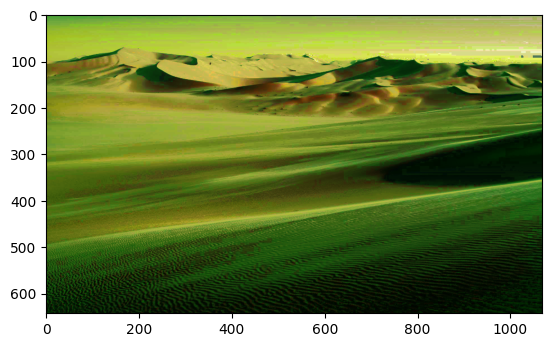

In [9]:
def color_transfer_idt(i0, i1, bins=300, n_rot=10, relaxation=1):  # implement by others
    n_dims = i0.shape[1]

    d0 = i0.T
    d1 = i1.T

    for i in range(n_rot):

        r = sp.stats.special_ortho_group.rvs(n_dims).astype(np.float32)

        d0r = np.dot(r, d0)
        d1r = np.dot(r, d1)
        d_r = np.empty_like(d0)

        for j in range(n_dims):

            lo = min(d0r[j].min(), d1r[j].min())
            hi = max(d0r[j].max(), d1r[j].max())

            p0r, edges = np.histogram(d0r[j], bins=bins, range=[lo, hi])
            p1r, _     = np.histogram(d1r[j], bins=bins, range=[lo, hi])

            cp0r = p0r.cumsum().astype(np.float32)
            cp0r /= cp0r[-1]

            cp1r = p1r.cumsum().astype(np.float32)
            cp1r /= cp1r[-1]

            f = np.interp(cp0r, cp1r, edges[1:])

            d_r[j] = np.interp(d0r[j], edges[1:], f, left=0, right=bins)

        d0 = relaxation * np.linalg.solve(r, (d_r - d0r)) + d0

        print(f'Iteration {i+1}/{n_rot} completed.')

    return d0.T

flat_source_img = source_img.reshape(-1, source_img.shape[-1])
flat_style_img = style_img.reshape(-1, source_img.shape[-1])
np.random.seed(77)
flat_transfered_img = color_transfer_idt(flat_source_img, flat_style_img, bins=300, n_rot=20, relaxation=1)
transfered_img_idt = flat_transfered_img.reshape(source_img.shape).clip(0,1)
plt.imshow(transfered_img_idt)
Image.fromarray(np.uint8(255*transfered_img_idt)).save(f"images/idt_transfer/img{img_pair_num}.png")

### show histograms of RGB channels of transfered_img

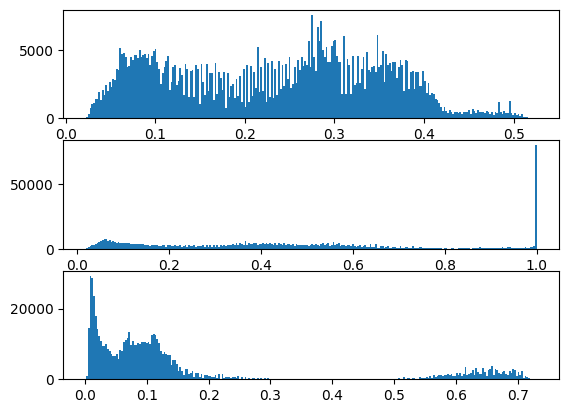

In [10]:
transfered_rs, transfered_gs, transfered_bs = transfered_img_basic[:,:,0].flatten(), transfered_img_basic[:,:,1].flatten(), transfered_img_basic[:,:,2].flatten()
fig, ax = plt.subplots(3)
ax[0].hist(transfered_rs, bins=256)
ax[1].hist(transfered_gs, bins=256)
ax[2].hist(transfered_bs, bins=256)
plt.show()

### Non Local Map Regularization

In [11]:
def compute_e_term(img_block, u_x, dimension, sigma=10):
    top,bottom,left,right = dimension
    u_x_block = u_x[np.newaxis,np.newaxis,:]
    u_x_block = np.repeat(np.repeat(u_x_block, bottom-top, axis=0), right-left, axis=1)
    ux_uy_dist = np.sum(np.power(img_block-u_x_block, 2), axis=2)
    e_power = -ux_uy_dist / np.power(sigma,2)
    e_term = np.exp(e_power)

    return e_term

def Yu(img, radius):
    Yu_img = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            top = np.maximum(i-radius, 0)
            bottom = np.minimum(i+radius+1, img.shape[0])
            left = np.maximum(j-radius, 0)
            right = np.minimum(j+radius+1, img.shape[1])
            dimension = [top,bottom,left,right]
            img_block = img[top:bottom, left:right]
            e_term = compute_e_term(img_block,img[i,j],dimension)
            e_term_3channel = np.repeat(e_term[:,:,np.newaxis], 3, axis=2)
            C = np.sum(e_term)
            Yu_img[i,j] = np.sum(np.reshape(np.multiply(img_block,e_term_3channel), (-1, img.shape[2])), axis=0)/C

            if(i%50==0 and j==0):
                print(f'{i} rows have been processed.')
    return Yu_img

def TMRu(source_img, transfered_img, radius=10, source_img_detail=None):
    print("computing Yu(transfered_img)...")
    Yu_transfered_img = Yu(transfered_img, radius)
    plt.imshow(Yu_transfered_img)
    plt.show()
    if (source_img_detail is None):
        print("computing Yu(source_img)...")
        Yu_source_img = Yu(source_img, radius)
        source_img_detail = source_img - Yu_source_img
        plt.imshow(Yu_source_img)
        plt.show()
    # modify source_img_detail
    source_img_detail *= transfered_img
    plt.imshow((source_img_detail/2)+0.5)
    plt.show()
    #TMR_img = Yu_transfered_img+source_img_detail
    TMR_img = np.clip(Yu_transfered_img+source_img_detail, 0, 1)

    transfered_img_detail = transfered_img - Yu_transfered_img
    return TMR_img, Yu_transfered_img, source_img_detail, transfered_img_detail


computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


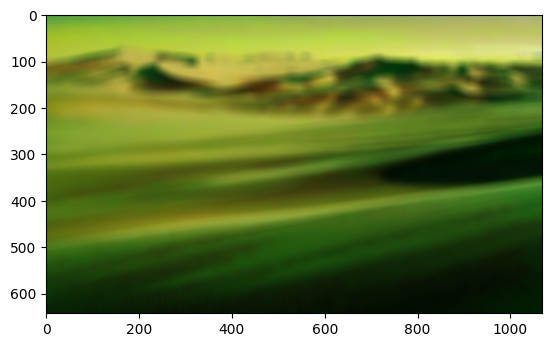

computing Yu(source_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


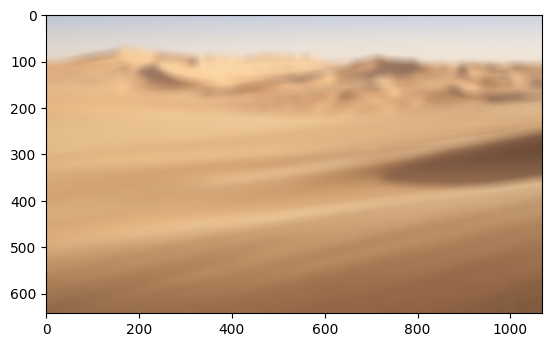

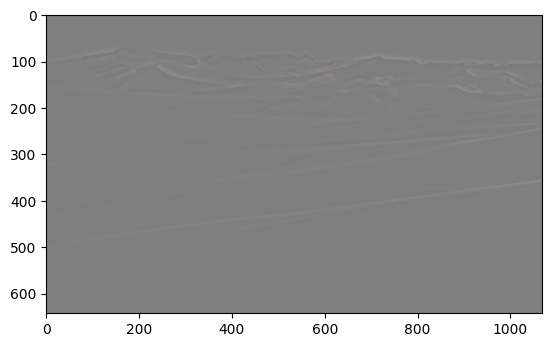

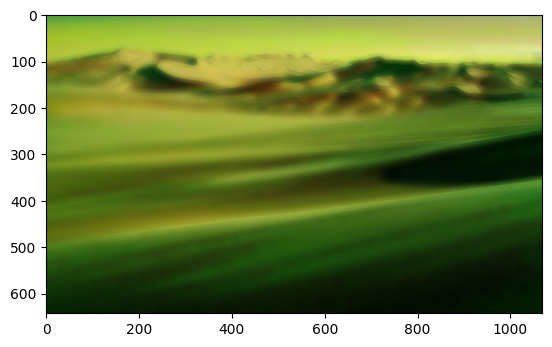

In [12]:
def TMR_one_iteration(source_img, transfered_img, radius=10):
    TMR_img, Yu_transfered_img, source_img_detail, transfered_img_detail = TMRu(source_img, transfered_img, radius)
    plt.imshow(TMR_img)
    plt.show()
    Image.fromarray(np.uint8(255*TMR_img)).save(f"images/TMR/one_iteration/img{img_pair_num}.png")
    return TMR_img, Yu_transfered_img, source_img_detail, transfered_img_detail

TMR_img, Yu_transfered_img, source_img_detail, transfered_img_detail = TMR_one_iteration(source_img, transfered_img_idt)

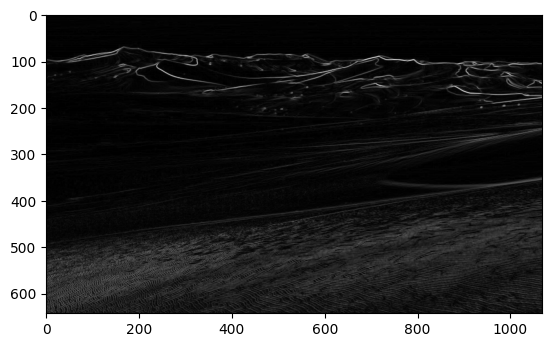

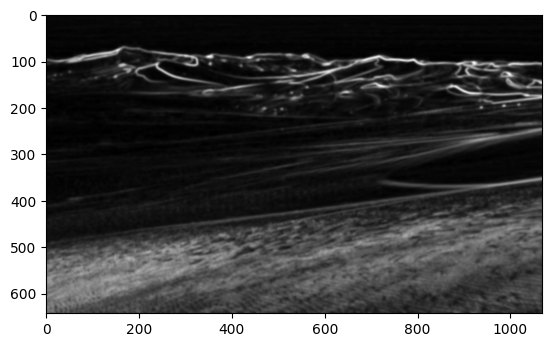

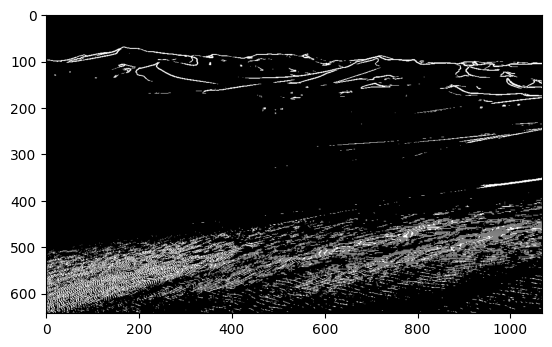

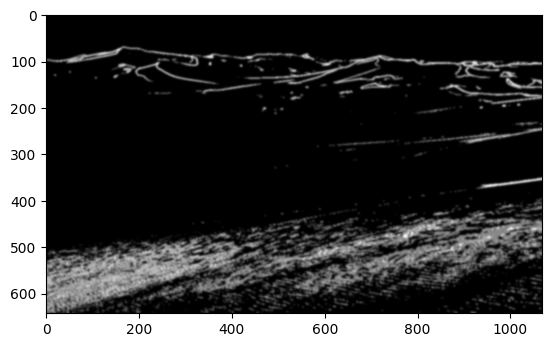

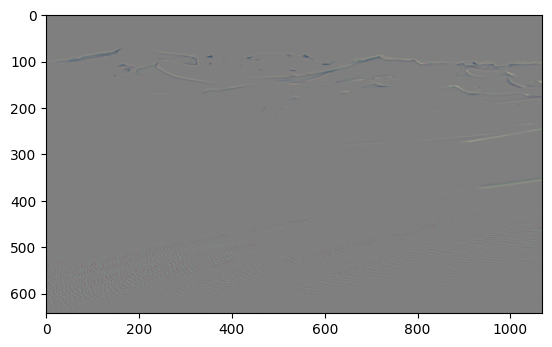

In [13]:
from scipy import ndimage
def show_detail(detail):
    plt.imshow((detail/2)+0.5)
    plt.show()

def my_TMR_filter(Yu_transfered_img, transfered_img_detail, source_img, transfered_img_idt):
    path = "images/TMR/my_TMR"
    sobel_h = ndimage.sobel(source_img, 0)  # horizontal gradient
    sobel_v = ndimage.sobel(source_img, 1)  # vertical gradient
    source_img_sobel = np.sqrt(sobel_h**2 + sobel_v**2)
    source_img_sobel = np.max(source_img_sobel, axis=2)
    source_img_sobel /= np.max(source_img_sobel)  # normalization
    source_img_sobel = np.repeat(source_img_sobel[:, :, np.newaxis], 3, axis=2)
    plt.imshow(source_img_sobel)
    plt.show()

    source_img_sobel_blur = ndimage.gaussian_filter(source_img_sobel, sigma=2)
    source_img_sobel_blur /= np.max(source_img_sobel_blur)
    plt.imshow(source_img_sobel_blur)
    plt.show()

    source_img_threshould = np.where(source_img_sobel>0.2, 1, 0).astype(np.float32)
    plt.imshow(source_img_threshould)
    plt.show()

    source_img_threshould_blur = ndimage.gaussian_filter(source_img_threshould, sigma=2)
    source_img_threshould_blur /= np.max(source_img_threshould_blur)
    plt.imshow(source_img_threshould_blur)
    plt.show()

    detail1 = transfered_img_detail * source_img_sobel
    detail2 = transfered_img_detail * source_img_sobel_blur
    detail3 = transfered_img_detail * source_img_threshould
    detail4 = transfered_img_detail * source_img_threshould_blur
    # show_detail(detail1)
    # show_detail(detail2)
    # show_detail(detail3)
    show_detail(detail4)

    # filtered_img1 = Yu_transfered_img + detail1
    # filtered_img1 = np.clip(filtered_img1, 0, 1)
    # filtered_img2 = Yu_transfered_img + detail2
    # filtered_img2 = np.clip(filtered_img2, 0, 1)
    # filtered_img3 = Yu_transfered_img + detail3
    # filtered_img3 = np.clip(filtered_img3, 0, 1)
    filtered_img4 = Yu_transfered_img + detail4
    filtered_img4 = np.clip(filtered_img4, 0, 1)

    # Image.fromarray(np.uint8(255*transfered_img_idt)).save(f"{path}/0.png")
    # Image.fromarray(np.uint8(255*filtered_img1)).save(f"{path}/1.png")
    # Image.fromarray(np.uint8(255*filtered_img2)).save(f"{path}/2.png")
    # Image.fromarray(np.uint8(255*filtered_img3)).save(f"{path}/3.png")
    Image.fromarray(np.uint8(255*filtered_img4)).save(f"{path}/{img_pair_num}.png")

my_TMR_filter(Yu_transfered_img, transfered_img_detail, source_img, transfered_img_idt)

Iteration 1 starts
computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


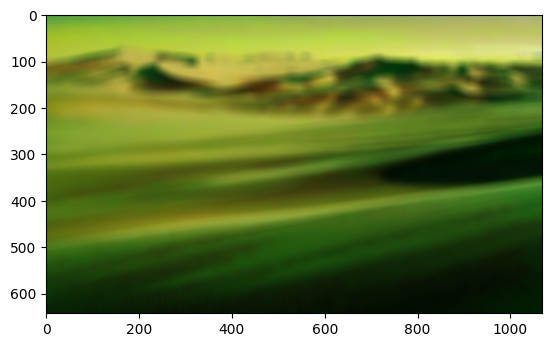

computing Yu(source_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


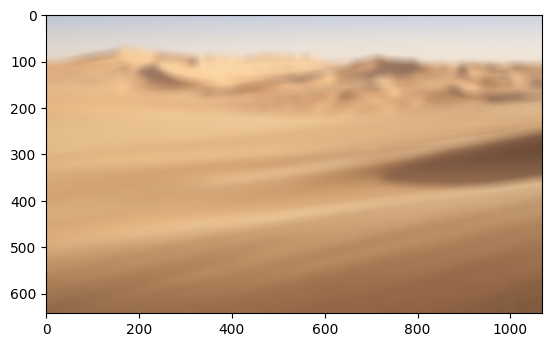

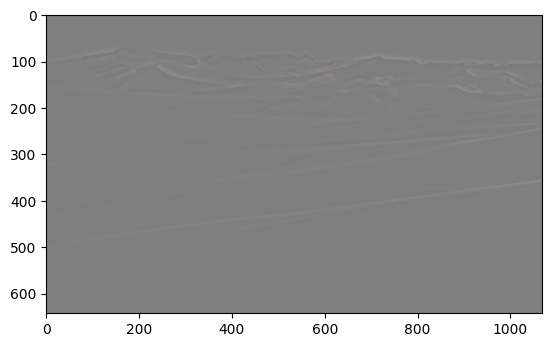

Iteration 2 starts
computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


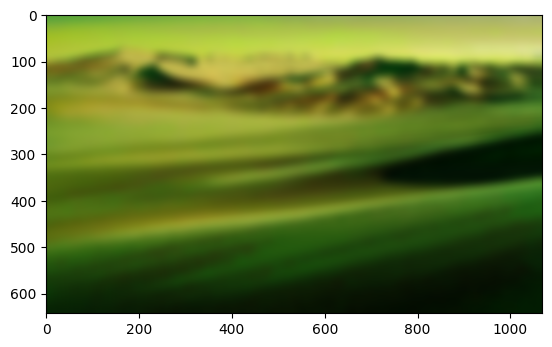

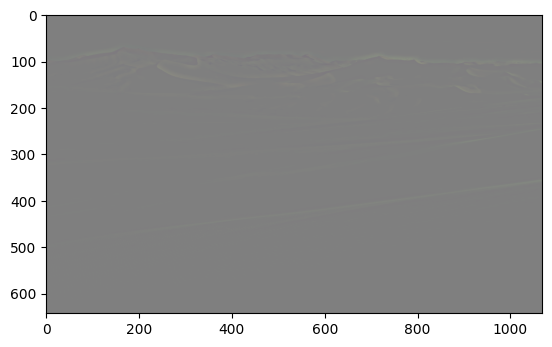

Iteration 3 starts
computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


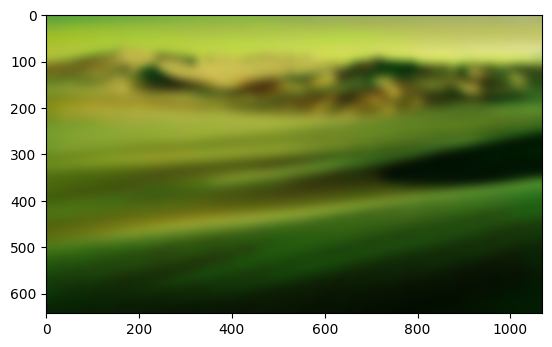

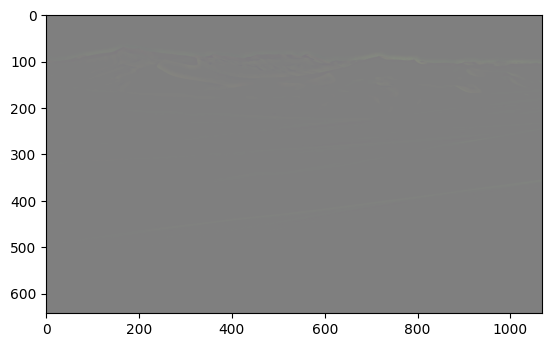

Iteration 4 starts
computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


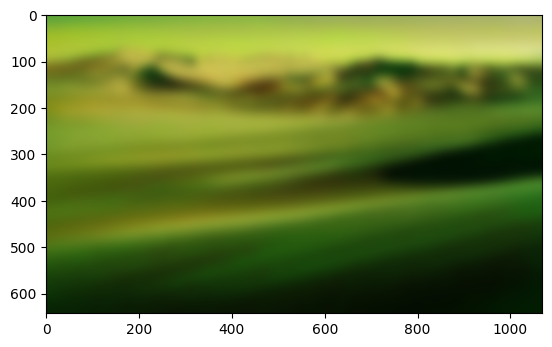

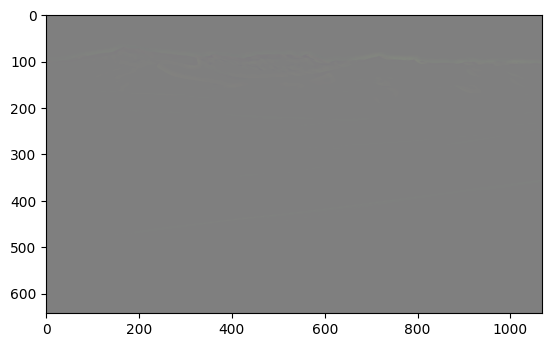

Iteration 5 starts
computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


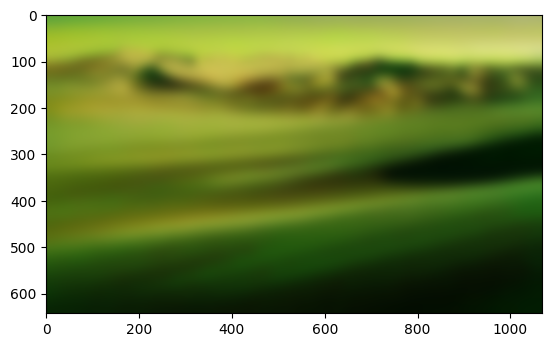

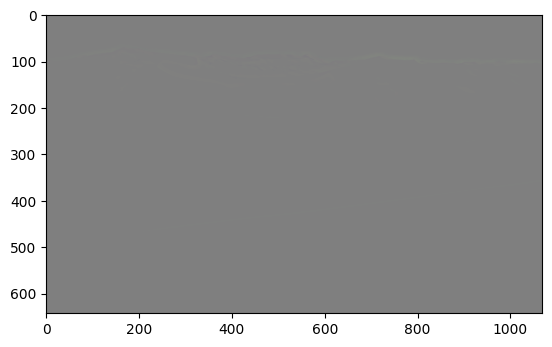

Iteration 6 starts
computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


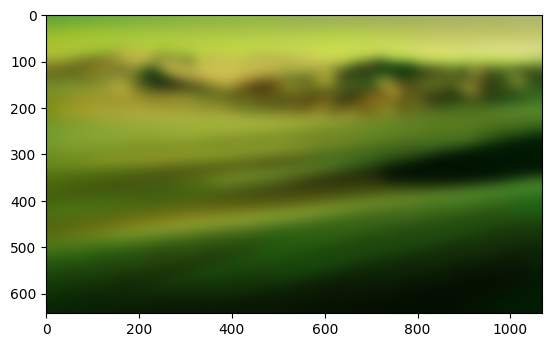

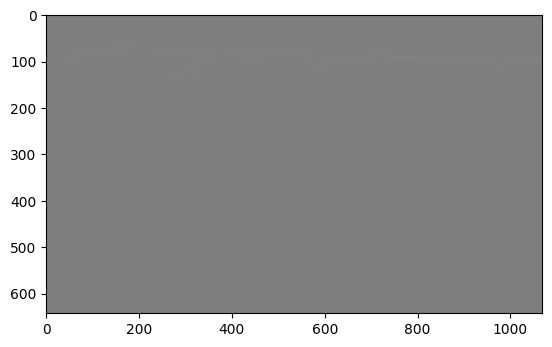

Iteration 7 starts
computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


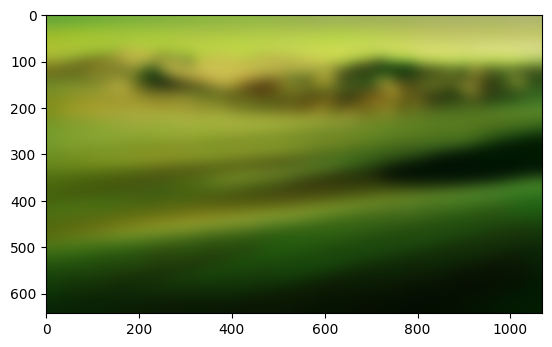

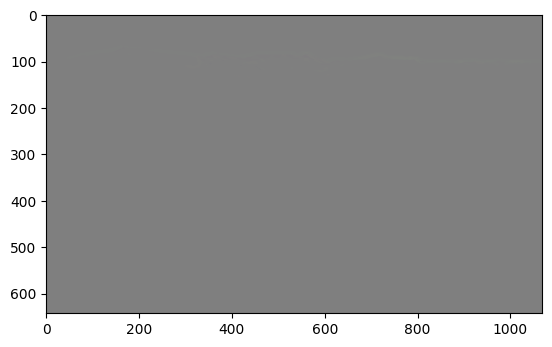

Iteration 8 starts
computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


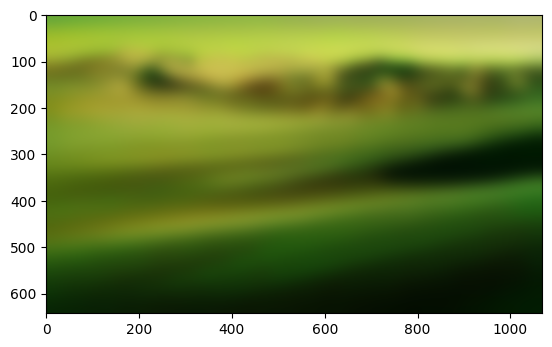

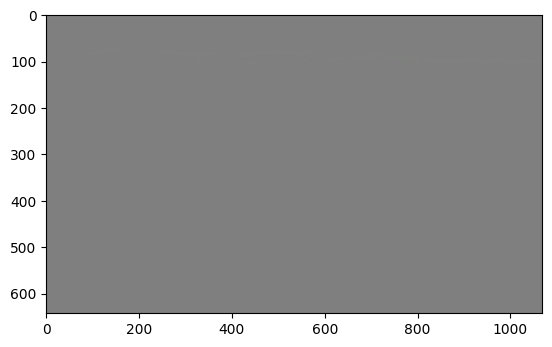

Iteration 9 starts
computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


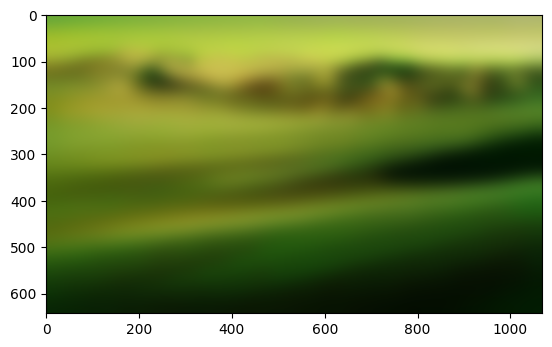

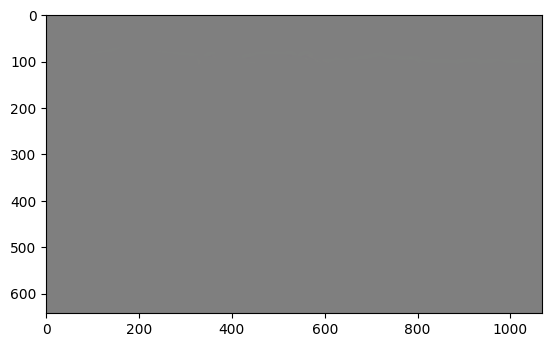

Iteration 10 starts
computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


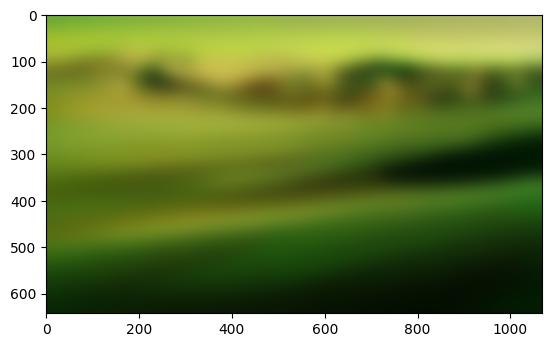

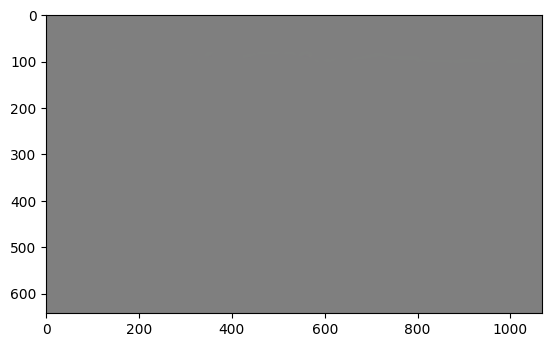

Iteration 11 starts
computing Yu(transfered_img)...
0 rows have been processed.
50 rows have been processed.
100 rows have been processed.
150 rows have been processed.
200 rows have been processed.
250 rows have been processed.
300 rows have been processed.
350 rows have been processed.
400 rows have been processed.
450 rows have been processed.
500 rows have been processed.
550 rows have been processed.
600 rows have been processed.


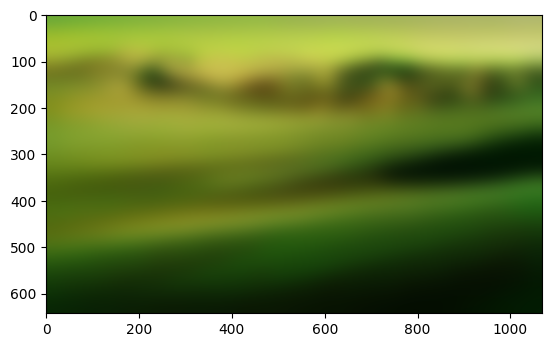

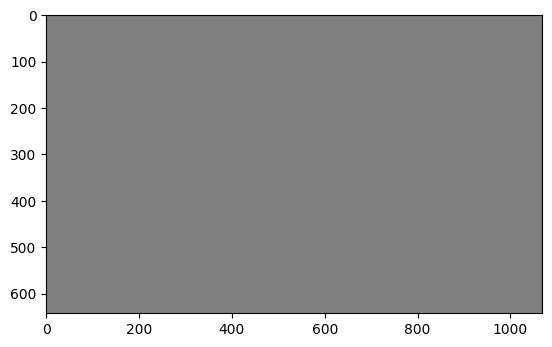

stop iteration


In [14]:
def is_converged(cur_img, prev_img):
    pixels = cur_img.shape[0]*cur_img.shape[1]
    ratio = 1e-2
    norm1 = np.sum(np.abs(cur_img-prev_img))
    return norm1 < pixels*ratio

def TMR_many_iteration(source_img, transfered_img, radius=10):
    iteration = 1
    prev_img = source_img
    cur_img = transfered_img
    source_img_detail = None
    while(True):
        save_path = f"images/TMR/many_iteration/img{img_pair_num}/iter_{iteration}.png"
        print(f"Iteration {iteration} starts")
        if(iteration==1):
            TMR_img, Yu_transfered_img, source_img_detail, transfered_img_detail = TMRu(source_img, cur_img, radius)
        else:
            TMR_img, Yu_transfered_img, source_img_detail, transfered_img_detail = TMRu(source_img, cur_img, radius, source_img_detail)
        source_img_detail = source_img_detail
        Image.fromarray(np.uint8(255*TMR_img)).save(save_path)
        if(is_converged(TMR_img, prev_img)):
            print("stop iteration")
            break
        prev_img = cur_img
        cur_img = TMR_img
        iteration += 1

TMR_many_iteration(source_img, transfered_img_idt)

### Frame to video

In [ ]:
def frames_to_video(image_folder, video_path, frame_width, frame_height, fps=5, img_postfix='.png'):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))
    images = glob.glob(os.path.join(image_folder, '*'+img_postfix))
    images.sort(key=lambda x: os.path.getmtime(x))
    init_img = cv2.imread(f'images/idt_transfer/img{img_pair_num}.png')
    video_writer.write(init_img)
    video_writer.write(init_img)
    video_writer.write(init_img)
    for image_file in images:
        img = cv2.imread(image_file)
        if img is not None:
            img = cv2.resize(img, (frame_width, frame_height))
            video_writer.write(img)
    video_writer.release()
    print(f'Video saved as {video_path}')

frames_to_video(f'images/TMR/many_iteration/img{img_pair_num}', f'images/TMR/many_iteration/video/video{img_pair_num}.mp4', width, height)